# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set(style='darkgrid')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix

import pickle

In [2]:
games = pd.read_csv('./Data/games.csv')
players = pd.read_csv('./Data/players.csv')
plays = pd.read_csv('./Data/plays.csv')
pff = pd.read_csv('./Data/PFFScoutingData.csv')
tracking_2018 = pd.read_csv('./Data/tracking2018.csv')
tracking_2019 = pd.read_csv('./Data/tracking2019.csv')
tracking_2020 = pd.read_csv('./Data/tracking2020.csv')

# Data Setup

### Concatenate Tracking Data and Orient all Kicks to the Right

In [3]:
# Concatenate tracking data
tracking_full = pd.concat([tracking_2018, tracking_2019, tracking_2020], axis=0)
tracking_full.reset_index(drop=True, inplace=True)

# Flip so all plays go begin with kick to the right
tracking_full.loc[tracking_full['playDirection'] == "left", 'x'] = 120-tracking_full.loc[tracking_full['playDirection'] == "left", 'x']
tracking_full.loc[tracking_full['playDirection'] == "left", 'y'] = 160/3-tracking_full.loc[tracking_full['playDirection'] == "left", 'y']

# Kickoff Coverage and Return Analysis

### Filter Plays and PFF Data to Kickoff Plays

In [4]:
# Filter for punts only
kickoff_plays = plays[plays['specialTeamsPlayType'] == 'Kickoff'].copy()

In [5]:
# Filter PFF data for punt plays
pff_kickoff_plays = pff[pff['kickType'].isin(['D', 'F', 'K', 'P', 'Q', 'B'])]

### Filter Tracking Data to Kickoff Plays

In [6]:
# Only keep plays considered punt plays by PFF
kickoff_tracking = tracking_full.merge(pff_kickoff_plays[['gameId', 'playId']],
                                       on=['gameId', 'playId'],
                                       how='inner'
                                      ).reset_index(drop=True)

### Prepare Tracking Data for Point in Time Metrics

In [7]:
# Merge player info to punt tracking data
play_cols = ['gameId', 'playId', 'kickerId', 'returnerId', 'possessionTeam', 'absoluteYardlineNumber', 'specialTeamsResult']
games_cols = ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']

kickoff_tracking = kickoff_tracking.merge(plays[play_cols], on=['gameId', 'playId'])\
                                   .merge(pff, on=['gameId', 'playId'])\
                                   .merge(games[games_cols], on='gameId')

In [8]:
# Convert merged ID columns to integer
kickoff_tracking['kickerId'].fillna(0, inplace=True)
kickoff_tracking['kickerId'] = kickoff_tracking['kickerId'].astype(int)
kickoff_tracking['returnerId'] = kickoff_tracking['returnerId'].str.split(';').str[0]
kickoff_tracking['returnerId'].fillna(0, inplace=True)
kickoff_tracking['returnerId'] = kickoff_tracking['returnerId'].astype(float)
#kickoff_tracking.dropna(subset = ['returnerId'], inplace=True)
#kickoff_tracking['returnerId'] = kickoff_tracking['returnerId'].astype(int)

In [9]:
# Flip the yardline number for plays going left
kickoff_tracking['absoluteYardlineNumber'] = np.where(kickoff_tracking['playDirection']=='left', 
                                                      (kickoff_tracking['absoluteYardlineNumber'] - 120) * -1,
                                                      kickoff_tracking['absoluteYardlineNumber']
                                                     )

# Adjust x to be relative to line of scrimmage
kickoff_tracking['x_adj'] = kickoff_tracking['x'] - kickoff_tracking['absoluteYardlineNumber']

In [10]:
# Create team name, team and number combination, and kicking team True/False columns
kickoff_tracking['jerseyNumber'].fillna(0, inplace=True)
kickoff_tracking['teamName'] = np.where(kickoff_tracking['team']=='football', 'football',
                                        np.where(kickoff_tracking['team']=='home', 
                                                 kickoff_tracking['homeTeamAbbr'],
                                                 kickoff_tracking['visitorTeamAbbr']
                                                )
                                       )

kickoff_tracking['teamNumber'] = kickoff_tracking['teamName'] + ' ' + kickoff_tracking['jerseyNumber'].astype(int).astype(str)

kickoff_tracking['kickingTeam'] = kickoff_tracking['teamName']==kickoff_tracking['possessionTeam']

In [11]:
# Create role player column to track punter/returner/football
kickoff_tracking['rolePlayer'] = np.where(kickoff_tracking['nflId']==kickoff_tracking['kickerId'], 'kicker',
                                             np.where(kickoff_tracking['nflId']==kickoff_tracking['returnerId'], 'returner',
                                                      np.where(kickoff_tracking['team']=='football', 'football', 'other'
                                                              )
                                                     )
                                         )

In [12]:
# Determine snap frame and create new frame column relative to the snap
kickoff_kicks = kickoff_tracking[kickoff_tracking['event']=='kickoff'][['gameId', 'playId', 'frameId', 'event']].drop_duplicates()
kickoff_kicks.rename(columns={'frameId' : 'kick'}, inplace=True)

kickoff_tracking = kickoff_tracking.merge(kickoff_kicks[['gameId', 'playId', 'kick']], on=['gameId', 'playId'])
kickoff_tracking['frameVsKick'] = kickoff_tracking['frameId'] - kickoff_tracking['kick']

### Calculate Point in Time Metrics for Each Frame

#### Team Penetration by Frame

In [13]:
# Calculate average team position and kicking team penetration by frame
exclude = ['kicker', 'returner', 'football']
group_cols = ['gameId', 'playId', 'frameVsKick', 'teamName']

ko_penetration_by_frame_kicking = kickoff_tracking[(~kickoff_tracking['rolePlayer'].isin(exclude)) &
                                                   (kickoff_tracking['kickingTeam'])
                                                  ].groupby(group_cols)['x_adj'].mean().reset_index()

ko_penetration_by_frame_receiving = kickoff_tracking[(~kickoff_tracking['rolePlayer'].isin(exclude)) &
                                                     (~kickoff_tracking['kickingTeam'])
                                                    ].groupby(group_cols)['x_adj'].mean().reset_index()


ko_team_penetration_by_frame = ko_penetration_by_frame_kicking.merge(ko_penetration_by_frame_receiving, on=['gameId', 'playId', 'frameVsKick'])
ko_team_penetration_by_frame.columns = ['gameId', 'playId', 'frameVsKick', 'kickTeam', 'kickTeamPosition', 'recTeam', 'recTeamPosition']
ko_team_penetration_by_frame['kickTeamPenetration'] = ko_team_penetration_by_frame['kickTeamPosition'] - ko_team_penetration_by_frame['recTeamPosition']

#### Vertical Spread and Deviation of Gaps by Frame

In [14]:
# Calculate vertical spread of the punt team
ko_kick_team_spread = kickoff_tracking[(kickoff_tracking['kickingTeam'])
                                      ].groupby(group_cols)['y'].agg({np.min,np.max}).reset_index()

ko_kick_team_spread['max_spread'] = ko_kick_team_spread['amax'] - ko_kick_team_spread['amin']

In [15]:
# Calculate standard deviation of the player gaps
ko_kick_team_gaps = kickoff_tracking[kickoff_tracking['kickingTeam']].sort_values(['gameId', 'playId', 'frameVsKick', 'y']).copy()

ko_kick_team_gaps['y_gap'] = ko_kick_team_gaps['y'].diff()

mask = ((ko_kick_team_gaps['gameId']==ko_kick_team_gaps['gameId'].shift(1)) &
        (ko_kick_team_gaps['playId']==ko_kick_team_gaps['playId'].shift(1)) &
        (ko_kick_team_gaps['frameVsKick']==ko_kick_team_gaps['frameVsKick'].shift(1))
       )

ko_kick_team_gaps['y_gap'] = np.where(mask!=True, np.nan, ko_kick_team_gaps['y_gap'])

ko_kick_team_gaps = ko_kick_team_gaps.groupby(['gameId', 'playId', 'frameVsKick'])['y_gap'].std().reset_index()
ko_kick_team_gaps.columns = ['gameId', 'playId', 'frameVsKick', 'gapStdDev']

In [16]:
# Merge gap deviation to spread dataframe
ko_kick_team_spread = ko_kick_team_spread.merge(ko_kick_team_gaps, on=['gameId', 'playId', 'frameVsKick'])

#### Nearest Defender to Returner by Frame

In [17]:
# Set up kick returner position dataframe
ko_returner_position = kickoff_tracking[kickoff_tracking['rolePlayer']=='returner'][['gameId', 'playId', 'frameVsKick', 'x', 'y']]
ko_returner_position.columns = ['gameId', 'playId', 'frameVsKick', 'x_returner', 'y_returner']

# For touchback plays, set returner position equal to the middle of the goal line
touchback_returner_position = kickoff_tracking[kickoff_tracking['specialTeamsResult']=='Touchback'][['gameId', 'playId', 'frameVsKick']].drop_duplicates()
touchback_returner_position['x_returner'] = 110
touchback_returner_position['y_returner'] = 53.3 / 2

# Concatenate return and touchback returner position dataframes
ko_returner_position = pd.concat([ko_returner_position, touchback_returner_position], axis=0).reset_index(drop=True)

# Merge returner position back to tracking data and calculate distance to the returner for all defensive players
kickoff_tracking = kickoff_tracking.merge(ko_returner_position, on=['gameId', 'playId', 'frameVsKick'])

kickoff_tracking['dist_to_returner'] = np.sqrt((kickoff_tracking['x_returner'] - kickoff_tracking['x'])**2 +\
                                               (kickoff_tracking['y_returner'] - kickoff_tracking['y'])**2)

exclude = ['football', 'returner']

ko_dist_to_returner = kickoff_tracking[(~kickoff_tracking['rolePlayer'].isin(exclude)) &
                                       (kickoff_tracking['kickingTeam'])
                                      ].groupby(['gameId', 'playId', 'frameVsKick'])['dist_to_returner'].agg({np.min,np.mean}).reset_index()

ko_dist_to_returner.columns = ['gameId', 'playId', 'frameVsKick', 'minDist', 'meanDist']

In [18]:
kickoff_tracking.specialTeamsResult.unique()

array(['Return', 'Touchback', 'Muffed', 'Fair Catch'], dtype=object)

### Combine Kickoff Details Into a Single Dataframe

In [19]:
def merge_frame_data(df1, df2, on_cols, merge_cols, how='inner', frame=[], rename_cols=[]):
    """
    Merge tracking data for specified frame(s) from specified df.
    """
    for f in frame:
        df1 = df1.merge(df2[df2['frameVsKick']==f][merge_cols], on=on_cols, how=how)
        if rename_cols:
            for col in rename_cols:
                df1.rename(columns={col : col + '_frame' + str(f)}, inplace=True)

    return df1

In [20]:
# Merge relevant columns from plays and pff dataframes
ko_pff_filtered = pff_kickoff_plays[['gameId', 'playId', 'hangTime', 'kickType', 'kickoffReturnFormation', 'kickDirectionActual']]
kickoff_plays_filtered = kickoff_plays[['gameId', 'playId', 'specialTeamsResult', 'penaltyCodes', 'kickLength', 
                                        'kickReturnYardage', 'playResult']]

kickoff_data_combined = ko_pff_filtered.merge(kickoff_plays_filtered, on=['gameId', 'playId'], how='inner')

In [21]:
# Merge team penetration data
on_cols = ['gameId', 'playId']
merge_cols = on_cols + ['kickTeam', 'recTeam', 'kickTeamPosition', 'recTeamPosition']
rename_cols = ['kickTeamPosition', 'recTeamPosition']

kickoff_data_combined = merge_frame_data(kickoff_data_combined,
                                         ko_team_penetration_by_frame,
                                         on_cols=on_cols,
                                         merge_cols=merge_cols,
                                         how='left',
                                         frame=[30],
                                         rename_cols=rename_cols
                                        )

merge_cols = on_cols + rename_cols

kickoff_data_combined = merge_frame_data(kickoff_data_combined,
                                         ko_team_penetration_by_frame,
                                         on_cols=on_cols,
                                         merge_cols=merge_cols,
                                         how='left',
                                         frame=[40, 50],
                                         rename_cols=rename_cols
                                        )

In [22]:
# Merge kick team spread and gap data
rename_cols = ['max_spread', 'gapStdDev']
merge_cols = on_cols + rename_cols

kickoff_data_combined = merge_frame_data(kickoff_data_combined,
                                         ko_kick_team_spread,
                                         on_cols=on_cols,
                                         merge_cols=merge_cols,
                                         how='left',
                                         frame=[30, 40, 50],
                                         rename_cols=rename_cols
                                        )

In [23]:
# Merge defender distance data
rename_cols = ['minDist', 'meanDist']
merge_cols = on_cols + rename_cols

kickoff_data_combined = merge_frame_data(kickoff_data_combined,
                                         ko_dist_to_returner,
                                         on_cols=on_cols,
                                         merge_cols=merge_cols,
                                         how='left',
                                         frame=[30, 40, 50],
                                         rename_cols=rename_cols
                                        )

In [24]:
# Reorder the columns in the final dataframe
new_order = ['gameId',
             'playId',
             'kickTeam',
             'recTeam',
             'kickType',
             'kickDirectionActual',
             'kickoffReturnFormation',
             'specialTeamsResult',
             'penaltyCodes',
             'kickLength',
             'kickReturnYardage',
             'playResult',
             'hangTime',
             'kickTeamPosition_frame30',
             'kickTeamPosition_frame40',
             'kickTeamPosition_frame50',
             'recTeamPosition_frame30',
             'recTeamPosition_frame40',
             'recTeamPosition_frame50',
             'max_spread_frame30',
             'max_spread_frame40',
             'max_spread_frame50',
             'gapStdDev_frame30',
             'gapStdDev_frame40',
             'gapStdDev_frame50',
             'minDist_frame30',
             'minDist_frame40',
             'minDist_frame50',
             'meanDist_frame30',
             'meanDist_frame40',
             'meanDist_frame50']

kickoff_data_combined = kickoff_data_combined[new_order]

### Explore Correlation and Collinearity

In [25]:
# Change NaN to zero for kickReturnYardage
kickoff_data_combined['kickReturnYardage'].fillna(0, inplace=True)

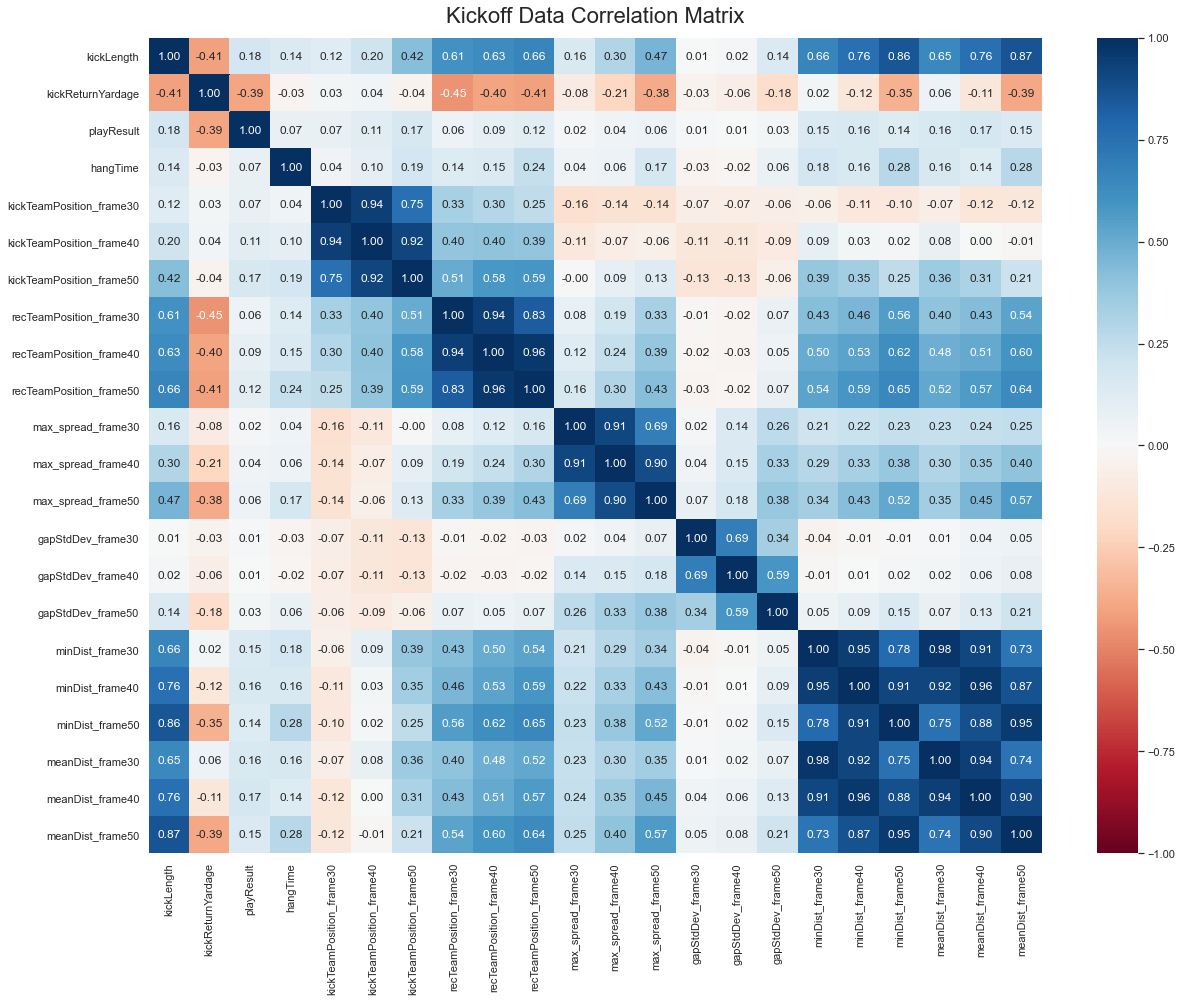

In [26]:
# Display correlation matrix
corr = kickoff_data_combined[new_order[9:]].corr()

plt.figure(figsize=[20,15])
ax = plt.axes()
plt.rcParams.update({'font.size': 12})
ax.set_title('Kickoff Data Correlation Matrix', fontsize=22, pad=15)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0)
plt.show();

In [27]:
# Drop output variables to perform for VIF calculation
output_var = ['kickReturnYardage', 'playResult']
linear_reg_vif = kickoff_data_combined[new_order[12:]].dropna()

# Create constant and run VIF calculation
X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       1619.742928
hangTime                       1.208586
kickTeamPosition_frame30      54.417195
kickTeamPosition_frame40     150.516627
kickTeamPosition_frame50      39.887767
recTeamPosition_frame30       34.524102
recTeamPosition_frame40      124.789219
recTeamPosition_frame50       49.241228
max_spread_frame30            12.517402
max_spread_frame40            35.714097
max_spread_frame50            15.272748
gapStdDev_frame30              2.211396
gapStdDev_frame40              2.968058
gapStdDev_frame50              1.824860
minDist_frame30              119.363704
minDist_frame40              172.945602
minDist_frame50               49.549342
meanDist_frame30             123.458616
meanDist_frame40             190.071910
meanDist_frame50              61.098110
dtype: float64

In [28]:
# New run of VIF, using frame 30 only
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame30', 'recTeamPosition_frame30',
                                        'max_spread_frame30', 'gapStdDev_frame30', 'minDist_frame30',
                                        'meanDist_frame30']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       1152.934336
hangTime                       1.044435
kickTeamPosition_frame30       1.276047
recTeamPosition_frame30        1.354681
max_spread_frame30             1.070092
gapStdDev_frame30              1.054646
minDist_frame30               15.621614
meanDist_frame30              15.199795
dtype: float64

In [29]:
# VIF with frame 30, exclude mean distance
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame50', 'recTeamPosition_frame30',    
                                        'max_spread_frame30', 'gapStdDev_frame30', 'minDist_frame30',
                                       ]].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       852.117977
hangTime                      1.102367
kickTeamPosition_frame50      1.300022
recTeamPosition_frame30       1.442557
max_spread_frame30            1.047286
gapStdDev_frame30             1.033148
minDist_frame30               1.235249
dtype: float64

In [30]:
# New run of VIF, frame 40 only
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame40', 'recTeamPosition_frame40',
                                        'max_spread_frame40', 'gapStdDev_frame40', 'minDist_frame40',
                                        'meanDist_frame40']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       999.946393
hangTime                      1.041914
kickTeamPosition_frame40      1.352270
recTeamPosition_frame40       1.600809
max_spread_frame40            1.146984
gapStdDev_frame40             1.061738
minDist_frame40              10.707354
meanDist_frame40             10.772842
dtype: float64

In [31]:
# VIF with frame 40, exclude mean distance
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame50', 'recTeamPosition_frame40',    
                                        'max_spread_frame40', 'gapStdDev_frame40', 'minDist_frame40',
                                       ]].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       727.538446
hangTime                      1.096334
kickTeamPosition_frame50      1.401347
recTeamPosition_frame40       1.789787
max_spread_frame40            1.146326
gapStdDev_frame40             1.050016
minDist_frame40               1.428633
dtype: float64

In [32]:
# New run of VIF, frame 50 only
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame50', 'recTeamPosition_frame50',    
                                        'max_spread_frame50', 'gapStdDev_frame50', 'minDist_frame50',
                                        'meanDist_frame50']].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       716.234145
hangTime                      1.120991
kickTeamPosition_frame50      1.604109
recTeamPosition_frame50       2.374665
max_spread_frame50            1.592216
gapStdDev_frame50             1.200998
minDist_frame50               9.870077
meanDist_frame50             10.636828
dtype: float64

In [33]:
# VIF with frame 50, exclude mean distance
linear_reg_vif = kickoff_data_combined[['hangTime', 'kickTeamPosition_frame50', 'recTeamPosition_frame50',    
                                        'max_spread_frame50', 'gapStdDev_frame50', 'minDist_frame50',
                                       ]].dropna()

X = sm.tools.add_constant(linear_reg_vif)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
display(vif)

const                       663.060913
hangTime                      1.117277
kickTeamPosition_frame50      1.521359
recTeamPosition_frame50       2.320759
max_spread_frame50            1.538606
gapStdDev_frame50             1.176909
minDist_frame50               1.946548
dtype: float64

# Run Linear Regression

In [34]:
# Set feature and target columns and create separate dataframes (drop NA)
x_cols = ['kickLength', 'hangTime', 'kickTeamPosition_frame40', 'recTeamPosition_frame40',
          'max_spread_frame40', 'gapStdDev_frame40', 'minDist_frame40']

y_cols = ['kickReturnYardage']

kickoff_reg_data = kickoff_data_combined[x_cols + y_cols].dropna()

X = kickoff_reg_data[x_cols]
Y = kickoff_reg_data[y_cols]

In [35]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [36]:
# Initialize, train, and score Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=13)
rf_regressor.fit(x_train, y_train)

score = rf_regressor.score(x_test, y_test)

print('Random Forest Regressor R-Squared:  ' + str(format(score, '.4f')))

<ipython-input-36-344ff6391918>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(x_train, y_train)


Random Forest Regressor R-Squared:  0.6445


In [37]:
# Perform grid search for optimal Random Forest Regressor parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_regressor = RandomForestRegressor(random_state=13)
rf_random = RandomizedSearchCV(estimator=rf_regressor,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=13,
                               n_jobs = -1)

In [38]:
# Train and score best estimator
rf_random.fit(x_train, y_train)
rf_random.best_params_
rf_random_score = rf_random.best_estimator_.score(x_test, y_test)

print('Random Forest Regressor R-Squared:  ' + str(format(rf_random_score, '.4f')))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Random Forest Regressor R-Squared:  0.6538


In [39]:
# Display feature importances for best scoring estimator
best_rf_regressor = rf_random.best_estimator_
pd.Series(best_rf_regressor.feature_importances_, index=x_train.columns).sort_values(ascending=False)

kickLength                  0.569084
minDist_frame40             0.185374
recTeamPosition_frame40     0.101608
kickTeamPosition_frame40    0.084564
hangTime                    0.024525
gapStdDev_frame40           0.017458
max_spread_frame40          0.017387
dtype: float64

# Classification Model

In [40]:
def sequential_backward(model_data, target, classifier):
    """
    Accept a classification model and the full train/test data. Remove features one by one
    by determining the feature whose removal results in the highest accuracy score. Return
    a list of features in order of removal and a dataframe with all feature combinations
    and their accuracy scores, sorted by highest accuracy.
    """
    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    backward_order = []

    while test_columns:
        cols = test_columns + [target]
        data = model_data[cols]

        X = data.drop(columns=target)
        Y = data[target]
        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        score = accuracy_score(y_test, y_pred, normalize = True)

        test_instance = {'combo' : ', '.join(test_columns), 'score' : score, 'length' : len(test_columns)}
        feature_combos = feature_combos.append(test_instance, ignore_index=True)

        feature_importance = pd.Series(classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
        remove = feature_importance.index[-1]

        test_columns.remove(remove)
        backward_order.extend([remove])

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return backward_order, sorted_combos

In [41]:
def sequential_forward(model_data, target, classifier):
    """
    Accept a classification model and the full train/test data. Find the single feature
    that provides the best classification on its own. Then add featurues one by one
    by determining the feature whose addition results in the highest accuracy score. Return
    a list of features in order of addition and a dataframe with all feature combinations
    and their accuracy scores, sorted by highest accuracy.
    """
    test_columns = list(model_data.columns)
    test_columns.remove(target)
    
    feature_combos = pd.DataFrame()

    forward_order = []
    i = 1

    while test_columns:
        for col in test_columns:
            cols = [target] + forward_order + [col]
            data = model_data[cols].copy()
            
            X = data.drop(columns=target)
            Y = data[target]
            
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_test)

            score = accuracy_score(y_test, y_pred, normalize = True)

            test_instance = {'combo' : ', '.join(cols), 'score' : score, 'length' : i}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)

        remove = feature_combos[feature_combos['length']==i].sort_values('score', ascending=False).reset_index().loc[0,'combo'].split(', ')[-1]

        test_columns.remove(remove)
        forward_order.extend([remove])
        i += 1

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    sorted_combos = sorted_combos.drop_duplicates(subset='length', keep='first')
    
    return forward_order, sorted_combos

In [42]:
def balance_target(df, target):
    """
    Reduce all target classes to the level of the minority class.
    """
    
    limit = df[target].value_counts()[-1]
    
    balanced_df = pd.DataFrame()
    
    # Loop through each of the possible classes
    for value in df[target].value_counts().index:
        subset = df[df[target] == value]
        subset = subset.sample(limit, random_state=13)
        balanced_df = pd.concat([balanced_df, subset])
    
    # Return the final dataframe
    return balanced_df

In [43]:
# Make copy of punt data for classification, remove muffed punts and plays with penalties
kickoff_data_classification = kickoff_data_combined.copy()

kickoff_data_classification['penaltyCodes'] = kickoff_data_classification['penaltyCodes'].astype(str)

kickoff_data_classification = kickoff_data_classification[(kickoff_data_classification['specialTeamsResult'].isin(['Touchback', 'Return'])) &
                                                          (kickoff_data_classification['penaltyCodes'] == 'nan')]

In [44]:
# Add target bucket column for kick return yardage
conditions = [kickoff_data_classification['kickReturnYardage'].le(20), 
              kickoff_data_classification['kickReturnYardage'].gt(20) & kickoff_data_classification['kickReturnYardage'].le(30),
              kickoff_data_classification['kickReturnYardage'].gt(30)
             ]

choices = ['<20', '20-30', '30+']

kickoff_data_classification['kickReturnYardageBucket'] = np.select(conditions, choices)

In [45]:
# Create one hot encoding for kickoff formation
conditions = [kickoff_data_classification['kickoffReturnFormation']=='8-0-2',
              kickoff_data_classification['kickoffReturnFormation']=='8-0-1',
              kickoff_data_classification['kickoffReturnFormation']=='8-1-0',
              kickoff_data_classification['kickoffReturnFormation']=='7-0-3', 
              kickoff_data_classification['kickoffReturnFormation']=='5-3-2',
              kickoff_data_classification['kickoffReturnFormation']=='6-2-2',
              kickoff_data_classification['kickoffReturnFormation']=='6-0-3',
              kickoff_data_classification['kickoffReturnFormation']=='9-0-1',
              kickoff_data_classification['kickoffReturnFormation']=='8-1-1',
              kickoff_data_classification['kickoffReturnFormation']=='7-1-2',
              kickoff_data_classification['kickoffReturnFormation']=='6-0-4',
              kickoff_data_classification['kickoffReturnFormation']=='5-0-4',
              kickoff_data_classification['kickoffReturnFormation']=='9-0-0',
              kickoff_data_classification['kickoffReturnFormation']=='10-0-0']

choices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13]

kickoff_data_classification['kickoffReturnFormation'] = np.select(conditions, choices)

In [46]:
# Convert kick direction to float (Center is 0, L/R is 1)
kickoff_data_classification['kickDirectionActual'] = np.where(kickoff_data_classification['kickDirectionActual']=='C', 0, 1)

In [47]:
# Mark touchbacks in the target column
kickoff_data_classification['kickReturnYardageBucket'] = np.where(kickoff_data_classification['specialTeamsResult']=='Touchback',
                                                                  'Touchback',
                                                                  kickoff_data_classification['kickReturnYardageBucket'])

In [48]:
# Drop NA's and balance classes 
kickoff_data_classification.dropna(inplace=True)
kickoff_classification_balance = balance_target(kickoff_data_classification, 'kickReturnYardageBucket')

kickoff_classification_balance.kickReturnYardageBucket.value_counts()

20-30        331
Touchback    331
<20          331
30+          331
Name: kickReturnYardageBucket, dtype: int64

## Baseline Model

In [49]:
# Establish feature and target columns and set the dataframes for modeling
x_cols = ['kickLength', 'hangTime','kickDirectionActual', 'kickoffReturnFormation',
          'kickTeamPosition_frame30', 'recTeamPosition_frame30',
          'kickTeamPosition_frame40', 'recTeamPosition_frame40',
          'kickTeamPosition_frame50', 'recTeamPosition_frame50',
          'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50',
          'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50', 
          'minDist_frame30', 'minDist_frame40', 'minDist_frame50',
          'meanDist_frame40', 'meanDist_frame40', 'meanDist_frame50']

y_cols = ['kickReturnYardageBucket']

X = kickoff_classification_balance[x_cols]
Y = kickoff_classification_balance[y_cols]

In [50]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [51]:
# Initialize, train, and score the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=13)

rf_classifier.fit(x_train, y_train)

y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)

rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)

print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

<ipython-input-51-7ce278b3636a>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(x_train, y_train)


Training Score:   1.0
Test Score: 0.6716981132075471


In [52]:
# Display the feature performances
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

recTeamPosition_frame30     0.108371
kickLength                  0.082906
recTeamPosition_frame40     0.070890
meanDist_frame50            0.059554
meanDist_frame40            0.057474
recTeamPosition_frame50     0.056699
minDist_frame30             0.056258
minDist_frame40             0.053658
meanDist_frame40            0.053066
minDist_frame50             0.050888
max_spread_frame50          0.038762
hangTime                    0.038374
gapStdDev_frame30           0.037512
gapStdDev_frame50           0.036172
gapStdDev_frame40           0.034731
max_spread_frame30          0.033410
max_spread_frame40          0.031608
kickTeamPosition_frame30    0.030821
kickTeamPosition_frame50    0.030098
kickTeamPosition_frame40    0.029501
kickDirectionActual         0.005538
kickoffReturnFormation      0.003710
dtype: float64

## Find Optimal Feature Combinations

In [53]:
# Establish the initial dataframe with all possible features
kickoff_classification_balance = kickoff_classification_balance[x_cols + y_cols]

In [54]:
# Run forward and backward feature selection
backward_order, sorted_combos_backward = sequential_backward(kickoff_classification_balance, 'kickReturnYardageBucket', rf_classifier)
forward_order, sorted_combos_forward = sequential_forward(kickoff_classification_balance, 'kickReturnYardageBucket', rf_classifier)

In [55]:
# Display feature order from backward selection
backward_order[::-1]

['recTeamPosition_frame30',
 'meanDist_frame50',
 'minDist_frame30',
 'kickLength',
 'minDist_frame40',
 'recTeamPosition_frame40',
 'minDist_frame50',
 'meanDist_frame40',
 'recTeamPosition_frame50',
 'hangTime',
 'max_spread_frame50',
 'gapStdDev_frame50',
 'gapStdDev_frame30',
 'meanDist_frame40',
 'gapStdDev_frame40',
 'max_spread_frame40',
 'kickTeamPosition_frame30',
 'max_spread_frame30',
 'kickTeamPosition_frame50',
 'kickTeamPosition_frame40',
 'kickDirectionActual',
 'kickoffReturnFormation']

In [56]:
# Show top combinations from backward selection
sorted_combos_backward[0:5]

,index,combo,length,score
0,9,"kickLength, hangTime, recTeamPosition_frame30,...",13.0,0.686792
1,10,"kickLength, hangTime, recTeamPosition_frame30,...",12.0,0.671698
2,3,"kickLength, hangTime, kickTeamPosition_frame30...",19.0,0.660377
3,8,"kickLength, hangTime, recTeamPosition_frame30,...",14.0,0.660377
4,6,"kickLength, hangTime, recTeamPosition_frame30,...",16.0,0.652830


In [57]:
# Display feature order from forward selection
forward_order

['kickLength',
 'minDist_frame30',
 'gapStdDev_frame50',
 'recTeamPosition_frame30',
 'recTeamPosition_frame50',
 'hangTime',
 'kickTeamPosition_frame50',
 'gapStdDev_frame30',
 'kickDirectionActual',
 'meanDist_frame50',
 'meanDist_frame40',
 'max_spread_frame30',
 'max_spread_frame50',
 'recTeamPosition_frame40',
 'kickTeamPosition_frame40',
 'kickoffReturnFormation',
 'minDist_frame50',
 'gapStdDev_frame40',
 'minDist_frame40',
 'max_spread_frame40',
 'kickTeamPosition_frame30',
 'meanDist_frame40']

In [58]:
# Show top combinations from forward selection
sorted_combos_forward[0:5]

,index,combo,length,score
0,203,"kickReturnYardageBucket, kickLength, minDist_f...",13.0,0.683019
1,219,"kickReturnYardageBucket, kickLength, minDist_f...",15.0,0.679245
2,236,"kickReturnYardageBucket, kickLength, minDist_f...",17.0,0.675472
3,211,"kickReturnYardageBucket, kickLength, minDist_f...",14.0,0.675472
4,196,"kickReturnYardageBucket, kickLength, minDist_f...",12.0,0.671698


In [59]:
# Set features as top feature combination from forward and backward selection
x_cols = sorted_combos_backward.combo[0].split(', ')[1:]

X = kickoff_classification_balance[x_cols]
Y = kickoff_classification_balance[y_cols]

In [60]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=13)

In [61]:
# Initialize, train, and score the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=13)

rf_classifier.fit(x_train, y_train)

y_pred_train = rf_classifier.predict(x_train)
y_pred_test = rf_classifier.predict(x_test)

rf_train_score = accuracy_score(y_train, y_pred_train, normalize = True)
rf_test_score = accuracy_score(y_test, y_pred_test, normalize = True)

print('Training Score:   ' + str(rf_train_score))
print('Test Score: ' + str(rf_test_score))

<ipython-input-61-e3b37aa64c0c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(x_train, y_train)


Training Score:   1.0
Test Score: 0.6452830188679245


In [62]:
# Display feature importances for Random Forest Classifier
pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

recTeamPosition_frame30    0.126960
meanDist_frame50           0.096183
recTeamPosition_frame40    0.095757
minDist_frame50            0.082938
minDist_frame30            0.082457
recTeamPosition_frame50    0.077824
meanDist_frame40           0.075604
meanDist_frame40           0.071168
minDist_frame40            0.068827
max_spread_frame50         0.060485
hangTime                   0.056389
gapStdDev_frame30          0.055156
gapStdDev_frame50          0.050253
dtype: float64

## Hyperparameter Tuning on Top Classifier Model

In [63]:
# Run grid search for Random Forest Classifier
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_classifier = RandomForestClassifier(random_state=13)
rf_random = RandomizedSearchCV(estimator=rf_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=13,
                               n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
/Users/davidwismer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=13),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=13, verbose=2)

In [64]:
# Display optimal Random Forest Classifier parameters
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [65]:
# Score the best of the Random Forest Classifier models
rf_random_score = rf_random.best_estimator_.score(x_test, y_test)

print('Random Forest Accuracy Score:  ' + str(format(rf_random_score, '.4f')))

Random Forest Accuracy Score:  0.6528


In [66]:
# Display feature importances for the best Random Forest Classifier models
best_rf_classifier = rf_random.best_estimator_

pd.Series(best_rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)

recTeamPosition_frame30    0.173882
meanDist_frame50           0.100131
recTeamPosition_frame40    0.097850
minDist_frame50            0.083789
meanDist_frame40           0.075749
minDist_frame40            0.075598
recTeamPosition_frame50    0.074283
minDist_frame30            0.073608
meanDist_frame40           0.072502
max_spread_frame50         0.045860
gapStdDev_frame30          0.043316
hangTime                   0.042933
gapStdDev_frame50          0.040502
dtype: float64

# Confusion Matrices

In [67]:
def confusion(classifier, x_test, y_test, y_pred, model, cmap):
    """
    Plot a confusion matrix for a given classifier and its test data.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    fig.patch.set_alpha(0)

    norm_list = ['true', 'pred']
    titles = ['Normalized by Actual', 'Normalized by Prediction']
    labels = ['30+', '20-30', '<20', 'Touchback']
    
    fig.suptitle(model + ' Confusion Matrices', fontsize=24, fontweight='bold')

    for ax, norm, title in zip(axes.flatten(), norm_list, titles):
        plot_confusion_matrix(classifier, 
                              x_test, 
                              y_test, 
                              ax=ax, 
                              cmap=cmap,
                              normalize=norm,
                              values_format='.1%',
                              labels=labels
                             )
        ax.set_title(title, pad=15, fontsize=20, fontweight='bold')
        ax.set_xlabel('Predicted Classification', labelpad=20, fontsize=20, fontweight='bold')
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=18)
        ax.set_yticklabels(labels, ha='right', fontsize=18)
        ax.set_ylabel('True Classification', labelpad=20, fontsize=20, fontweight='bold')
        ax.grid(None)
    
    plt.tight_layout(pad=2.2)  
    plt.show();

In [68]:
# Make predictions using the best Random Forest Classifier
y_pred = best_rf_classifier.predict(x_test)

In [371]:
# Create custom colormap for use in heatmaps
colors = [(1, 1, 1), ((106/256, 235/256, 245/256)), ((22/256, 159/256, 169/256)), ((14/256, 95/256, 101/256))] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Custom", colors, N=30)

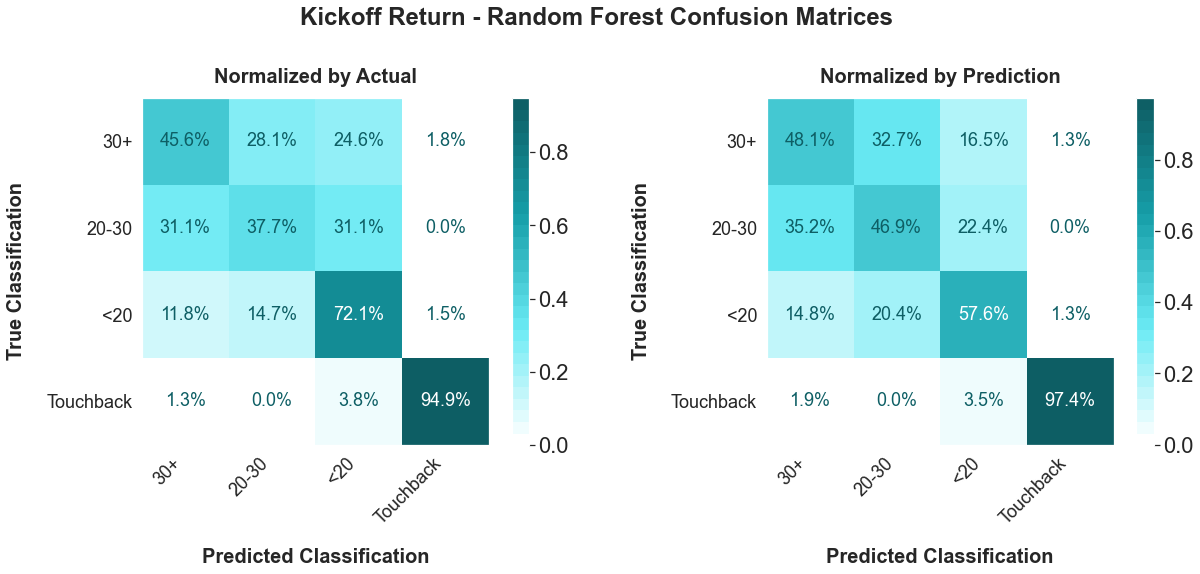

In [372]:
# Display confusion matrices
sns.set(font_scale=2.0)
plt.rcParams.update({'font.size': 18})

confusion(classifier=best_rf_classifier, x_test=x_test, y_test=y_test, y_pred=y_pred, model='Kickoff Return - Random Forest', cmap=cm)

# Kickoff Return Difficulty

In [72]:
kickoff_tracking.specialTeamsResult.unique()

array(['Return', 'Touchback', 'Muffed', 'Fair Catch'], dtype=object)

In [77]:
# Determine plays where the punt was received and returned, exclude muffed punts, fair catches, and penalty plays
kick_received = kickoff_tracking[(kickoff_tracking['event']=='kick_received')][['gameId', 'playId']]
kick_received = kick_received.merge(plays[['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers']], on=['gameId', 'playId'])

kick_received['penaltyTeam'] = np.where(kick_received.apply(lambda x: str(x['possessionTeam']) in str(x['penaltyJerseyNumbers']), axis=1),
                                        np.where(kick_received.apply(lambda x: ';' in str(x["penaltyJerseyNumbers"]), axis=1), 'Both', 'Kicking'),
                                        np.where(kick_received['penaltyJerseyNumbers'].astype(str)=='nan', 'None', 'Receiving')
                                       )

kick_returned = kick_received[((kick_received['specialTeamsResult']=='Return')) &
                              (~(kick_received['penaltyTeam'].isin(['Both', 'Receiving'])))
                             ]

In [81]:
# Create columns displaying the frameVsSnap for start and end of the return
starting_cols = ['gameId', 'playId', 'specialTeamsResult', 'possessionTeam', 'penaltyJerseyNumbers', 'penaltyTeam'] 
merge_cols = ['gameId', 'playId', 'frameVsKick']

kick_returned = kick_returned.merge(kickoff_tracking[kickoff_tracking['event']=='kick_received'][merge_cols],
                                    on=['gameId', 'playId'], how='left')

kick_returned = kick_returned.merge(kickoff_tracking[kickoff_tracking['event']=='out_of_bounds'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_rec', '_oob'))

kick_returned = kick_returned.merge(kickoff_tracking[kickoff_tracking['event']=='tackle'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_oob', '_tackle'))

kick_returned = kick_returned.merge(kickoff_tracking[kickoff_tracking['event']=='touchdown'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_tackle', '_td'))

kick_returned = kick_returned.merge(kickoff_tracking[kickoff_tracking['event']=='fumble'][merge_cols],
                                    on=['gameId', 'playId'], how='left', suffixes=('_td', '_fumble'))


kick_returned.columns = starting_cols + ['returnStart', 'outOfBounds', 'tackle', 'touchdown', 'fumble']

kick_returned = kick_returned.drop_duplicates()

kick_returned['returnEnd'] = kick_returned[['outOfBounds','tackle', 'touchdown']].min(axis=1)
kick_returned.dropna(subset=['returnEnd'], inplace=True)

In [85]:
# Exclude all plays with fumbles
kick_returned = kick_returned[kick_returned['fumble'].astype(str)=='nan']

In [84]:
# Calculate the distance between each defender and the football, as well as average and minimum by frame
football_position = kickoff_tracking[kickoff_tracking['rolePlayer']=='football'][['gameId', 'playId', 'frameVsKick', 'x', 'y']]
football_position.columns = ['gameId', 'playId', 'frameVsKick', 'x_football', 'y_football']

kickoff_tracking = kickoff_tracking.merge(football_position, on=['gameId', 'playId', 'frameVsKick'])

kickoff_tracking['dist_to_football'] = np.sqrt((kickoff_tracking['x_football'] - kickoff_tracking['x'])**2 + (kickoff_tracking['y_football'] - kickoff_tracking['y'])**2)

dist_to_football = kickoff_tracking[(kickoff_tracking['kickingTeam'])].groupby(['gameId', 'playId', 'frameVsKick'])['dist_to_football']\
                                                                      .agg({np.min,np.mean})\
                                                                      .reset_index()

dist_to_football.columns = ['gameId', 'playId', 'frameVsKick', 'minDist_football', 'meanDist_football']

In [87]:
# Filter tracking data to show frames that occurred during the return
kickoff_tracking_during_return = kickoff_tracking.merge(kick_returned[['gameId', 'playId', 'returnStart', 'returnEnd']], on=['gameId', 'playId'])

kickoff_tracking_during_return.dropna(subset=['returnStart', 'returnEnd'], inplace=True)

kickoff_tracking_during_return = kickoff_tracking_during_return[(kickoff_tracking_during_return['frameVsKick']>=kickoff_tracking_during_return['returnStart']) &
                                                                (kickoff_tracking_during_return['frameVsKick']<=kickoff_tracking_during_return['returnEnd'])
                                                               ]

In [88]:
# Calculate whether each defender was within two yards of the football during the return
kickoff_tracking_during_return['defender_within_two_yds'] = np.where((kickoff_tracking_during_return['dist_to_football'] <= 2.0) &
                                                                     (kickoff_tracking_during_return['kickingTeam']) &
                                                                     (kickoff_tracking_during_return['rolePlayer']!='football'), 1, 0)

In [89]:
# Show punt return touchdowns sorted by number of defenders within two yards throughout the play
close_defenders = kickoff_tracking_during_return.groupby(['gameId', 'playId'])['defender_within_two_yds'].sum().reset_index().sort_values('defender_within_two_yds', ascending=False)

In [94]:
# Determine the length of the return in frames (time)
kickoff_tracking_during_return['returnTime'] = kickoff_tracking_during_return['returnEnd'] - kickoff_tracking_during_return['returnStart']

return_length = kickoff_tracking_during_return[['gameId', 'playId', 'frameVsKick', 'x_football', 'y_football']].drop_duplicates()

return_length['x_change'] = return_length['x_football'].diff()
return_length['y_change'] = return_length['y_football'].diff()
return_length['football_movement'] = np.sqrt(return_length['x_change']**2 + return_length['y_change']**2)


mask = ((return_length['gameId']==return_length['gameId'].shift(1)) &
        (return_length['playId']==return_length['playId'].shift(1))
       )

return_length['football_movement'] = np.where(mask!=True, np.nan, return_length['football_movement'])

return_length = return_length.groupby(['gameId', 'playId'])['football_movement'].sum().reset_index()

In [96]:
# Merge difficulty metrics
return_difficulty = return_length.merge(close_defenders, on=['gameId', 'playId'], how='left')

return_difficulty = return_difficulty.merge(kickoff_tracking_during_return[['gameId', 'playId', 'returnTime']].drop_duplicates(),
                                            on=['gameId', 'playId'], how='left'
                                           )

In [98]:
# Add broken tackles to the return difficulty metrics
pff['brokenTackles'] = pff['missedTackler'].str.count(';') + 1

return_difficulty = return_difficulty.merge(pff[['gameId', 'playId', 'brokenTackles']],
                                            on=['gameId', 'playId'], how='left'
                                           )

return_difficulty['brokenTackles'].fillna(0, inplace=True)

In [103]:
# Convert return difficulty table to percentile ranking for each column and create average column (Difficulty)
return_difficulty_perc = return_difficulty.copy()

for col in ['football_movement', 'defender_within_two_yds', 'returnTime', 'brokenTackles']:
    return_difficulty_perc[col] = return_difficulty_perc[col].rank(pct=True)

return_difficulty_perc['difficulty'] = 0.25 * (return_difficulty_perc['football_movement'] +
                                               return_difficulty_perc['defender_within_two_yds'] +
                                               return_difficulty_perc['returnTime'] +
                                               return_difficulty_perc['brokenTackles']
                                              )

In [109]:
# Merge identifying information to the return difficulty table
return_difficulty_perc = return_difficulty_perc.merge(games[['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr']],
                                                      on=['gameId'])

return_difficulty_perc = return_difficulty_perc.merge(kickoff_tracking[['gameId', 'playId', 'possessionTeam', 'returnerId']].drop_duplicates(),
                                                      on=['gameId', 'playId'])

return_difficulty_perc = return_difficulty_perc.merge(players[['nflId', 'displayName']], left_on=['returnerId'], right_on=['nflId'])

return_difficulty_perc['returnTeam'] = np.where(return_difficulty_perc['possessionTeam']==return_difficulty_perc['homeTeamAbbr'],
                                                return_difficulty_perc['visitorTeamAbbr'],
                                                return_difficulty_perc['homeTeamAbbr']
                                               )

return_difficulty_perc = return_difficulty_perc.merge(kick_returned[['gameId', 'playId', 'touchdown']], on=['gameId', 'playId'])

# Mark touchdown returns
return_difficulty_perc['touchdown'] = np.where(return_difficulty_perc['touchdown'] > 0, 'Yes', 'No')

In [365]:
return_difficulty_perc[return_difficulty_perc['touchdown']=='Yes'].sort_values('difficulty', ascending=False)

,gameId,playId,football_movement,defender_within_two_yds,returnTime,brokenTackles,difficulty,season,week,homeTeamAbbr,visitorTeamAbbr,possessionTeam,returnerId,nflId,displayName,returnTeam,touchdown
178,2019111704,2047,0.999589,0.783217,0.999177,0.876183,0.914541,2019,11,MIA,BUF,BUF,43475.0,43475,Jakeem Grant,MIA,Yes
118,2018090903,3300,0.992184,0.699095,0.991567,0.876183,0.889757,2018,1,MIA,TEN,MIA,42973.0,42973,Darius Jennings,TEN,Yes
1573,2019122908,2061,1.000000,0.653229,0.998766,0.876183,0.882044,2019,17,KC,LAC,LAC,47839.0,47839,Mecole Hardman,KC,Yes
2239,2020101110,2229,0.999177,0.521185,0.999589,0.996709,0.879165,2020,5,CLE,IND,CLE,52619.0,52619,Isaiah Rodgers,IND,Yes
236,2019102009,972,0.998766,0.622378,0.997738,0.876183,0.873766,2019,7,CHI,NO,NO,39975.0,39975,Cordarrelle Patterson,CHI,Yes
1035,2018121609,442,0.993418,0.182230,0.993213,0.979844,0.787176,2018,15,SF,SEA,SEA,46309.0,46309,Richie James,SF,Yes
2094,2020092800,1132,0.994652,0.269231,0.992184,0.876183,0.783063,2020,3,BAL,KC,KC,52500.0,52500,Devin Duvernay,BAL,Yes
1776,2020102509,1496,0.996709,0.120938,0.995681,0.979844,0.773293,2020,7,DEN,KC,DEN,46522.0,46522,Byron Pringle,KC,Yes
219,2018102102,1452,0.997121,0.120938,1.000000,0.876183,0.748560,2018,7,CHI,NE,CHI,39975.0,39975,Cordarrelle Patterson,NE,Yes
440,2018122309,1461,0.995475,0.120938,0.993213,0.876183,0.746452,2018,16,NYJ,GB,GB,35527.0,35527,Andre Roberts,NYJ,Yes


In [110]:
# Prepare return difficulty table for presentation
presentation_order = ['season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'possessionTeam', 'returnTeam',
                      'displayName', 'touchdown', 'difficulty', 'defender_within_two_yds', 'football_movement', 
                      'returnTime', 'brokenTackles']

new_names = ['Season', 'Week', 'Home', 'Away', 'Kick Team', 'Return Team', 'Returner', 'Touchdown', 'Difficulty', 'Defender Proximity',
             'Total Movement', 'Return Time', 'Broken Tackles']

return_difficulty_presentation = return_difficulty_perc[presentation_order]

return_difficulty_presentation.columns = new_names

In [111]:
# Display punt return TD's sorted by difficulty
cm = sns.color_palette('RdYlGn', as_cmap=True)
heatmap_cols = ['Difficulty', 'Defender Proximity', 'Total Movement', 'Return Time', 'Broken Tackles']

return_difficulty_presentation[return_difficulty_presentation['Touchdown']=='Yes'].sort_values('Difficulty', ascending=False)\
                                                                                  .style.hide_index()\
                                                                                  .background_gradient(cmap=cm, subset=heatmap_cols)


Season,Week,Home,Away,Kick Team,Return Team,Returner,Touchdown,Difficulty,Defender Proximity,Total Movement,Return Time,Broken Tackles
2019,11,MIA,BUF,BUF,MIA,Jakeem Grant,Yes,0.914541,0.783217,0.999589,0.999177,0.876183
2018,1,MIA,TEN,MIA,TEN,Darius Jennings,Yes,0.889757,0.699095,0.992184,0.991567,0.876183
2019,17,KC,LAC,LAC,KC,Mecole Hardman,Yes,0.882044,0.653229,1.000000,0.998766,0.876183
2020,5,CLE,IND,CLE,IND,Isaiah Rodgers,Yes,0.879165,0.521185,0.999177,0.999589,0.996709
2019,7,CHI,NO,NO,CHI,Cordarrelle Patterson,Yes,0.873766,0.622378,0.998766,0.997738,0.876183
2018,15,SF,SEA,SEA,SF,Richie James,Yes,0.787176,0.182230,0.993418,0.993213,0.979844
2020,3,BAL,KC,KC,BAL,Devin Duvernay,Yes,0.783063,0.269231,0.994652,0.992184,0.876183
2020,7,DEN,KC,DEN,KC,Byron Pringle,Yes,0.773293,0.120938,0.996709,0.995681,0.979844
2018,7,CHI,NE,CHI,NE,Cordarrelle Patterson,Yes,0.748560,0.120938,0.997121,1.000000,0.876183
2018,16,NYJ,GB,GB,NYJ,Andre Roberts,Yes,0.746452,0.120938,0.995475,0.993213,0.876183


In [112]:
return_difficulty_presentation.sort_values('Difficulty', ascending=False).head(20)\
                              .style.hide_index()\
                              .background_gradient(cmap=cm, subset=heatmap_cols)

Season,Week,Home,Away,Kick Team,Return Team,Returner,Touchdown,Difficulty,Defender Proximity,Total Movement,Return Time,Broken Tackles
2020,15,NYG,CLE,CLE,NYG,Dion Lewis,No,0.973519,0.986837,0.945701,0.981695,0.979844
2020,12,NE,ARI,ARI,NE,Donte Moncrief,No,0.968686,0.931098,0.980666,0.983135,0.979844
2020,15,LA,NYJ,NYJ,LA,Nsimba Webster,No,0.967966,0.987659,0.918552,0.985808,0.979844
2019,5,CIN,ARI,ARI,CIN,Brandon Wilson,No,0.961076,0.953311,0.957219,0.953928,0.979844
2020,8,GB,MIN,GB,MIN,K.J. Osborn,No,0.960099,0.897367,0.977376,0.985808,0.979844
2019,16,PHI,DAL,DAL,PHI,Boston Scott,No,0.959739,0.976759,0.899630,0.965858,0.996709
2018,12,PHI,NYG,PHI,NYG,Corey Coleman,No,0.953723,0.942616,0.912793,0.979638,0.979844
2018,14,LAC,CIN,CIN,LAC,Desmond King,No,0.951152,0.942616,0.879062,0.983135,0.999794
2019,10,CIN,BAL,BAL,CIN,Brandon Wilson,No,0.948632,0.956397,0.976142,0.985808,0.876183
2020,13,BAL,DAL,BAL,DAL,Tony Pollard,No,0.948427,0.945907,0.984369,0.987248,0.876183


# Kickoff Player Penetration

#### Filter for Normal Kickoff Plays without Penalties

In [142]:
# Determine list of plays that meet criteria:  no penalties, deep kickoff
kick_play_subset = plays.copy()
kick_play_subset = kick_play_subset.merge(pff[['gameId', 'playId', 'kickType']], on = ['gameId', 'playId'])

kick_play_subset['penaltyCodes'] = kick_play_subset['penaltyCodes'].astype(str)

kick_play_subset = kick_play_subset[(kick_play_subset['kickType'].isin(['D', 'F', 'B'])) &
                                    (kick_play_subset['penaltyCodes'] == 'nan')]

# Filter gunner and vise tracking data for punt plays meeting the above criteria
kick_play_subset['game_play'] = kick_play_subset['gameId'].astype(str) + '-' + kick_play_subset['playId'].astype(str)
coverage_tracking = kickoff_tracking[~(kickoff_tracking['rolePlayer'].isin(['football', 'kicker', 'returner']))].copy()
coverage_tracking['game_play'] = coverage_tracking['gameId'].astype(str) + '-' + coverage_tracking['playId'].astype(str)

coverage_tracking = coverage_tracking[coverage_tracking['game_play'].isin(kick_play_subset['game_play'])]

#### Calculate Coverage Player Downfield Penetration by Frame

In [143]:
# Determine kicking team player positions at the snap and add to tracking data
positions_at_snap = coverage_tracking[(coverage_tracking['frameVsKick']==0) &
                                      (coverage_tracking['kickingTeam'])
                                     ][['gameId', 'playId', 'nflId', 'x', 'y']]

In [145]:
positions_at_snap.columns = ['gameId', 'playId', 'nflId', 'x_snap', 'y_snap']
coverage_tracking = coverage_tracking.merge(positions_at_snap, on=['gameId', 'playId', 'nflId'])

In [146]:
# Calculate gunner penetration (yards downfield) in absolute terms and verus the vise position
coverage_tracking['player_penetration'] = coverage_tracking['x'] - coverage_tracking['x_snap']

#### Rank Punt Coverage Players by Penetration Metrics

In [150]:
def top_penetration(df, players, metric, frame, cutoff, id_field, ascend=False):
    """
    Return df with top players for given metric and frame of play. Only return if number of kicks cutoff is met.
    """
    
    # Calculate average of metric for given frame
    best_by_frame = df[df['frameVsKick']==frame].groupby(id_field)[[metric]]\
                                                .mean()\
                                                .reset_index()\
                                                .sort_values(metric, ascending=ascend)
    
    # Determine number of qualifying punt plays for each gunner/vise
    kick_count = df[df['frameVsKick']==frame].groupby(id_field)[[metric]].count().reset_index().sort_values(metric, ascending=ascend)

    # Merge punt play count to average by player and exclude players who do not meet the cutoff
    best_by_frame = best_by_frame.merge(kick_count, on=id_field).sort_values(metric + '_y', ascending=ascend)\
                                 .merge(players[['nflId', 'displayName']], left_on=id_field, right_on='nflId')
    
    best_by_frame.columns = [id_field, 'avg_' + metric, 'kick_plays', 'name']
    
    best_by_frame = best_by_frame[best_by_frame['kick_plays']>cutoff][['name', id_field, 'avg_' + metric, 'kick_plays']]\
                        .sort_values('avg_' + metric, ascending=ascend)
    
    # Add ranking column and return dataframe with ranking
    best_by_frame['rank'] = best_by_frame['avg_' + metric].rank(ascending=ascend).astype(int)
    
    return best_by_frame[['rank', id_field, 'name', 'avg_' + metric, 'kick_plays']].reset_index(drop=True)

In [151]:
# Establish number of kick plays required to be ranked
cutoff = 15

In [152]:
# Calculate absolute and relative penetration for gunners 3, 4, and 5 seconds into the play
penetration_frame30 = top_penetration(df=coverage_tracking, 
                                      players=players,
                                      metric='player_penetration', 
                                      frame=30, 
                                      cutoff=cutoff,
                                      id_field='nflId',
                                      ascend=False)

penetration_frame40 = top_penetration(df=coverage_tracking, 
                                      players=players,
                                      metric='player_penetration', 
                                      frame=40, 
                                      cutoff=cutoff,
                                      id_field='nflId',
                                      ascend=False)

penetration_frame50 = top_penetration(df=coverage_tracking, 
                                      players=players,
                                      metric='player_penetration', 
                                      frame=50, 
                                      cutoff=cutoff,
                                      id_field='nflId',
                                      ascend=False)

In [154]:
# Merge gunner rankings into a single dataframe and organize for presentation
original_cols = ['nflId', 'name', 'kick_plays', 'rank']
merge_cols = ['nflId', 'rank']

player_penetration_merged = penetration_frame30[original_cols].merge(penetration_frame40[merge_cols], on='nflId')

player_penetration_merged = player_penetration_merged.merge(penetration_frame50[merge_cols], on='nflId')

player_penetration_merged.columns = ['nflId', 'Name', 'Kick Plays', 'Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)']

#### Penetration Rankings

In [158]:
# Add "Average Rank" column, sort, add heatmap, and present
player_penetration_merged['Average Rank'] = player_penetration_merged[['Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)']].mean(axis=1)

cm = sns.color_palette('RdYlGn_r', as_cmap=True)

no_heatmap_cols = ['Name', 'Kick Plays']
heatmap_cols = ['Average Rank', 'Penetration (3 Sec)', 'Penetration (4 Sec)', 'Penetration (5 Sec)']

player_penetration_merged.sort_values('Average Rank')[no_heatmap_cols + heatmap_cols].style.hide_index()\
                                                                                     .background_gradient(cmap=cm,subset=heatmap_cols)

Name,Kick Plays,Average Rank,Penetration (3 Sec),Penetration (4 Sec),Penetration (5 Sec)
Travis Homer,109,1.333333,1,1,2
Devin Duvernay,39,3.666667,8,2,1
Taiwan Jones,131,4.333333,3,3,7
C.J. Board,25,4.666667,2,8,4
Keion Crossen,182,7.333333,4,6,12
Jayson Stanley,38,7.333333,15,4,3
Brandon Bolden,133,9.666667,12,9,8
Jonathan Owens,31,12.333333,9,13,15
Penny Hart,52,12.333333,18,14,5
Allen Lazard,53,16.666667,14,12,24


# Team Coverage and Return Rankings

In [316]:
# Group by team and year
# Return team position, kick team position, net position, mean distance, min distance...
# Build ranking table, also rank mean/median return yardage for comparison

In [317]:
team_coverage = kickoff_data_combined.copy()

In [318]:
team_coverage.head()

,gameId,playId,kickTeam,recTeam,kickType,kickDirectionActual,kickoffReturnFormation,specialTeamsResult,penaltyCodes,kickLength,...,max_spread_frame50,gapStdDev_frame30,gapStdDev_frame40,gapStdDev_frame50,minDist_frame30,minDist_frame40,minDist_frame50,meanDist_frame30,meanDist_frame40,meanDist_frame50
0,2018090600,37,PHI,ATL,D,R,8-0-2,Touchback,NaN,66.0,...,28.43,1.822581,1.908725,2.493454,43.315074,34.777659,26.721680,47.349863,39.615938,32.764497
1,2018090600,677,ATL,PHI,D,R,8-0-2,Return,NaN,64.0,...,27.73,1.382120,1.036091,0.830529,41.655877,32.455563,21.414710,46.866491,38.125917,27.616580
2,2018090600,1387,PHI,ATL,D,R,8-0-2,Touchback,NaN,72.0,...,29.35,1.792312,2.114106,1.976069,43.560943,34.237997,25.552301,47.497836,39.488950,32.304674
3,2018090600,1606,ATL,PHI,D,C,8-0-2,Return,OH,68.0,...,32.30,1.482838,1.486743,1.926044,43.415717,34.840243,22.361424,49.589226,43.393232,33.227796
4,2018090600,2225,ATL,PHI,D,C,8-0-2,Touchback,NaN,71.0,...,30.00,2.118707,2.211432,3.198496,42.359213,33.277214,24.581216,47.238964,38.928031,31.754004


In [319]:
team_coverage.columns

Index(['gameId', 'playId', 'kickTeam', 'recTeam', 'kickType',
       'kickDirectionActual', 'kickoffReturnFormation', 'specialTeamsResult',
       'penaltyCodes', 'kickLength', 'kickReturnYardage', 'playResult',
       'hangTime', 'kickTeamPosition_frame30', 'kickTeamPosition_frame40',
       'kickTeamPosition_frame50', 'recTeamPosition_frame30',
       'recTeamPosition_frame40', 'recTeamPosition_frame50',
       'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50',
       'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50',
       'minDist_frame30', 'minDist_frame40', 'minDist_frame50',
       'meanDist_frame30', 'meanDist_frame40', 'meanDist_frame50'],
      dtype='object')

In [320]:
team_coverage.penaltyCodes.unique()

array([nan, 'OH', 'UNRd', 'UNR;FMM', 'ILF', 'IBW', 'LBL', 'FMM', 'UNR',
       'WED', 'OFK', 'TAUd', 'TRPd', 'ILM', 'UNR;OH', 'OH;UNR', 'OH;UNRd',
       'OH;OH', 'ILHd', 'UNSd', 'IDT', 'OH;IBW', 'IDT;OH', 'IBB', 'UOHd',
       'UNS', 'UNRd;UNR', 'HC', 'UNRd;ILF', 'IBW;OH'], dtype=object)

In [321]:
team_coverage.kickType.unique()

array(['D', 'Q', 'P', 'F', 'K', 'B'], dtype=object)

In [322]:
team_coverage = team_coverage[(team_coverage['penaltyCodes'].astype(str)=='nan') &
                              (team_coverage['kickType'].isin(['D', 'F', 'B']))
                             ]

In [323]:
team_coverage = team_coverage.merge(games[['gameId', 'season']], on='gameId')
team_coverage['kickTeam_year'] = team_coverage['kickTeam'] + '-' + team_coverage['season'].astype(str)

In [324]:
team_coverage['recTeam_year'] = team_coverage['recTeam'] + '-' + team_coverage['season'].astype(str)

In [325]:
team_coverage['teamPenetration_frame30'] = team_coverage['kickTeamPosition_frame30'] - team_coverage['recTeamPosition_frame30']
team_coverage['teamPenetration_frame40'] = team_coverage['kickTeamPosition_frame40'] - team_coverage['recTeamPosition_frame40']
team_coverage['teamPenetration_frame50'] = team_coverage['kickTeamPosition_frame50'] - team_coverage['recTeamPosition_frame50']

In [326]:
team_coverage = team_coverage.merge(pff[['gameId', 'playId', 'brokenTackles']],
                                    on=['gameId', 'playId'], how='left')

team_coverage['brokenTackles'].fillna(0, inplace=True)

In [327]:
metric_list = ['kickTeamPosition_frame30', 'kickTeamPosition_frame40', 'kickTeamPosition_frame50','minDist_frame30', 'minDist_frame40', 'minDist_frame50', 'meanDist_frame30', 'meanDist_frame40', 'meanDist_frame50']
metric_list = ['kickTeamPosition_frame50','minDist_frame50', 'meanDist_frame50', 'brokenTackles'] # 'max_spread_frame50', 'gapStdDev_frame50',
metric_list = ['kickTeamPosition_frame50','recTeamPosition_frame50', 'teamPenetration_frame50'] # 'max_spread_frame50', 'gapStdDev_frame50',
kick_team_ranks = team_coverage[team_coverage['specialTeamsResult']=='Return'].groupby('kickTeam_year')[metric_list].mean().reset_index()
play_result_ranks = team_coverage[team_coverage['specialTeamsResult']=='Return'].groupby('kickTeam_year')['playResult'].median().reset_index()

In [328]:
kick_team_ranks = kick_team_ranks.merge(play_result_ranks, on='kickTeam_year')

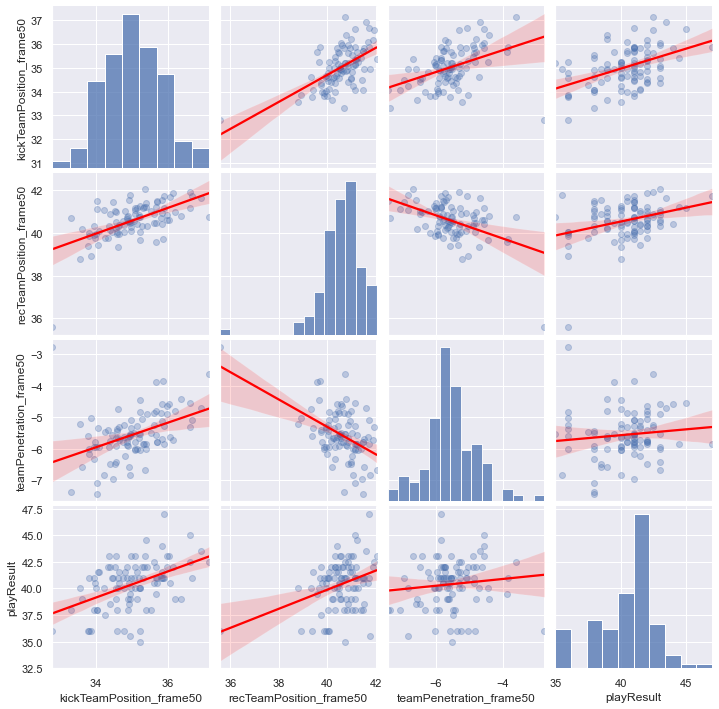

In [329]:
sns.set(font_scale=1.0)
plt.rcParams.update({'font.size': 10})

sns.pairplot(kick_team_ranks[metric_list + ['playResult']], kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})

In [313]:
high_is_good = ['playResult', 'kickTeamPosition_frame50', 'recTeamPosition_frame50', 'teamPenetration_frame50']
#low_is_good = [ 'minDist_frame50', 'meanDist_frame50', 'brokenTackles']

for col in high_is_good:
    kick_team_ranks[col] = kick_team_ranks[col].rank(pct=True)

#for col in low_is_good:
#    kick_team_ranks[col] = kick_team_ranks[col].rank(pct=True, ascending=False)

kick_team_ranks['average'] = kick_team_ranks[metric_list].mean(axis=1)

In [314]:
cm = sns.color_palette('RdYlGn', as_cmap=True)
kick_team_ranks.sort_values('playResult', ascending=False).style.hide_index().background_gradient(cmap=cm)

kickTeam_year,kickTeamPosition_frame50,recTeamPosition_frame50,teamPenetration_frame50,playResult,average
NO-2020,0.875000,0.947917,0.312500,1.000000,0.711806
BUF-2020,0.968750,0.791667,0.937500,0.989583,0.899306
ARI-2019,0.697917,0.833333,0.322917,0.979167,0.618056
ARI-2020,0.843750,0.375000,0.916667,0.968750,0.711806
SEA-2020,0.989583,0.927083,0.895833,0.958333,0.937500
CLE-2019,0.208333,0.322917,0.239583,0.916667,0.256944
HOU-2019,0.906250,0.500000,0.927083,0.916667,0.777778
JAX-2018,0.885417,0.625000,0.812500,0.916667,0.774306
JAX-2020,0.541667,0.739583,0.218750,0.916667,0.500000
DET-2018,0.281250,0.677083,0.125000,0.916667,0.361111


# EXPLORE THE DISTRIBUTIONS OF KEY METRICS FOR RETURNS OF DIFFERENT LENGTHS

In [332]:
kickoff_data_classification.columns

Index(['gameId', 'playId', 'kickTeam', 'recTeam', 'kickType',
       'kickDirectionActual', 'kickoffReturnFormation', 'specialTeamsResult',
       'penaltyCodes', 'kickLength', 'kickReturnYardage', 'playResult',
       'hangTime', 'kickTeamPosition_frame30', 'kickTeamPosition_frame40',
       'kickTeamPosition_frame50', 'recTeamPosition_frame30',
       'recTeamPosition_frame40', 'recTeamPosition_frame50',
       'max_spread_frame30', 'max_spread_frame40', 'max_spread_frame50',
       'gapStdDev_frame30', 'gapStdDev_frame40', 'gapStdDev_frame50',
       'minDist_frame30', 'minDist_frame40', 'minDist_frame50',
       'meanDist_frame30', 'meanDist_frame40', 'meanDist_frame50',
       'kickReturnYardageBucket'],
      dtype='object')

In [346]:
def kick_return_density(title, df, x):
    fig, ax = plt.subplots(figsize=[20, 8])
    plt.suptitle(title, fontweight='bold', fontsize=22)
    sns.kdeplot(data=df, x=x, hue='kickReturnYardageBucket',  ax=ax, common_norm=False)
    plt.grid(False)
    plt.show();

In [347]:
kickoff_data_classification[kickoff_data_classification['specialTeamsResult']!='Touchback'].kickType.unique()

array(['D', 'P', 'K', 'F'], dtype=object)

In [348]:
density_data = kickoff_data_classification[kickoff_data_classification['specialTeamsResult']!='Touchback'].sort_values('kickReturnYardage')

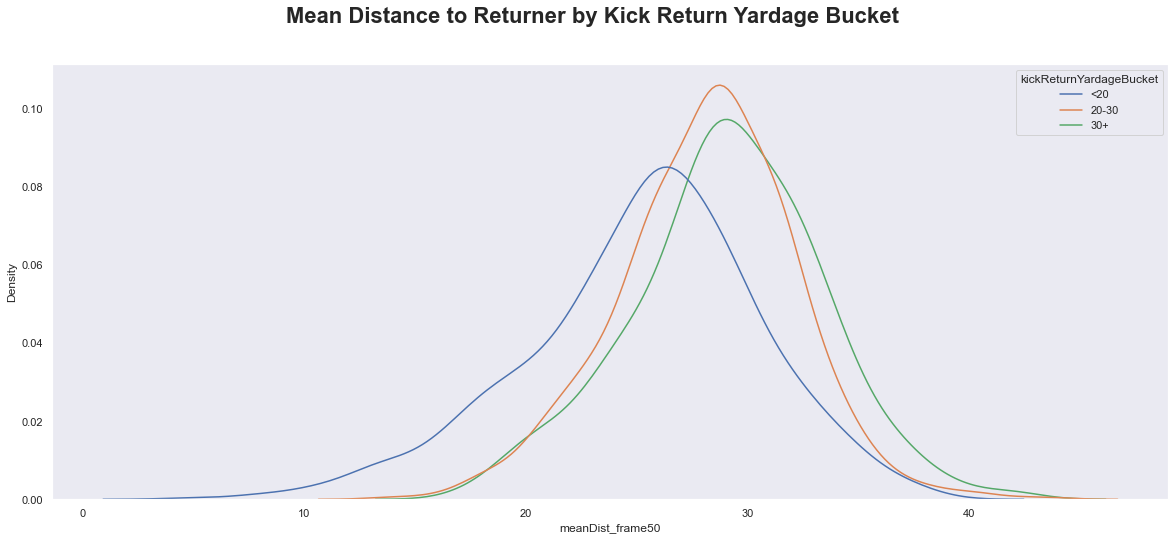

In [350]:
kick_return_density(title='Mean Distance to Returner by Kick Return Yardage Bucket',
                    df=density_data,
                    x='meanDist_frame50'
                   )

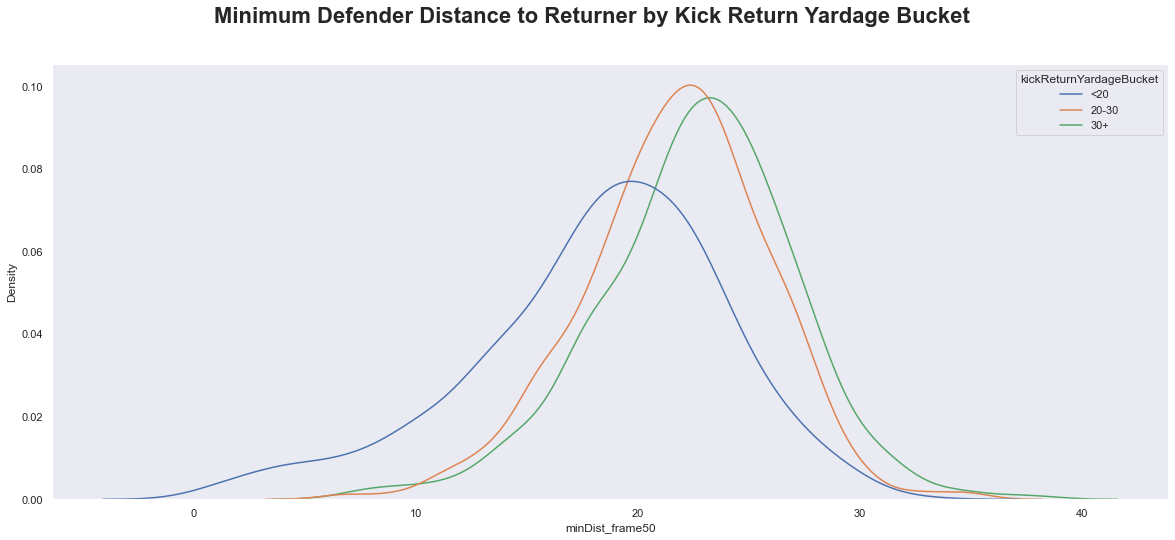

In [354]:
kick_return_density(title='Minimum Defender Distance to Returner by Kick Return Yardage Bucket',
                    df=density_data,
                    x='minDist_frame50'
                   )

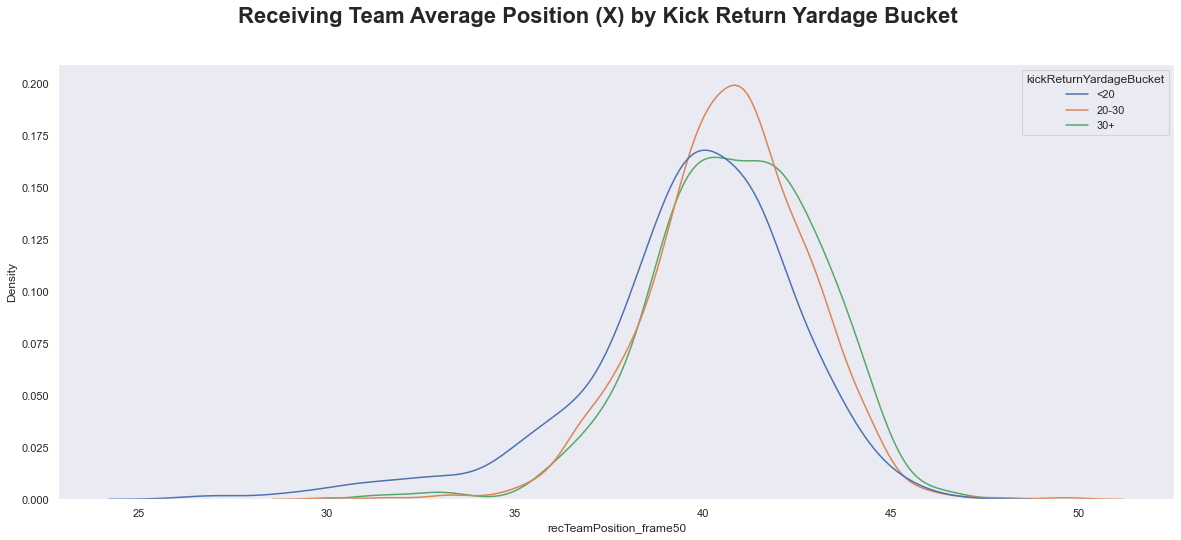

In [356]:
kick_return_density(title='Receiving Team Average Position (X) by Kick Return Yardage Bucket',
                    df=density_data,
                    x='recTeamPosition_frame50'
                   )

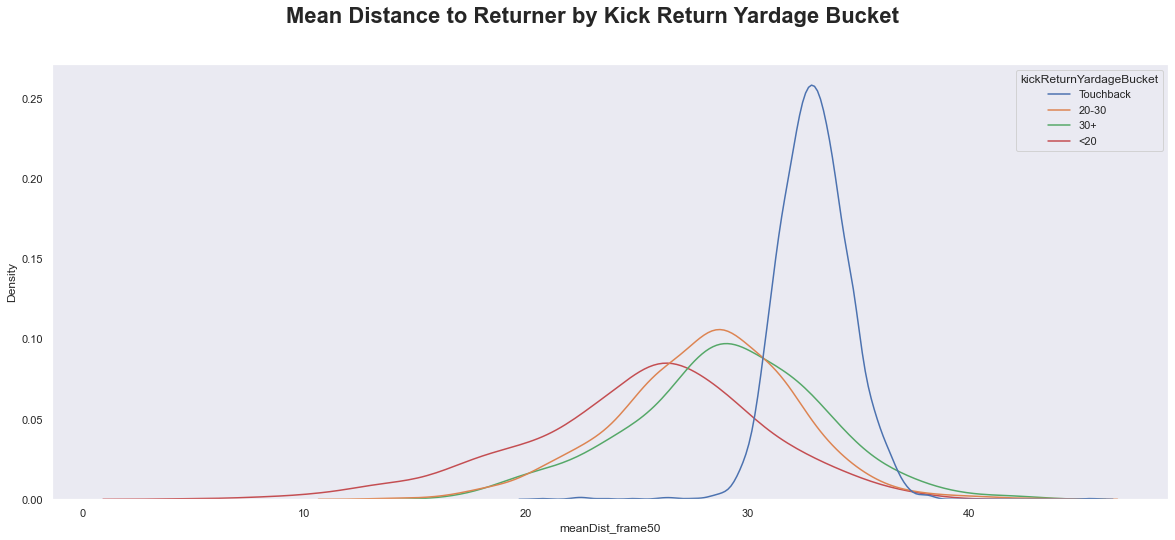

In [364]:
kick_return_density(title='Mean Distance to Returner by Kick Return Yardage Bucket',
                    df=kickoff_data_classification,
                    x='meanDist_frame50'
                   )